In [1]:
import pyspark
import pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
#from pyspark.ml.feature import StringIndexer

import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np

from dataclasses import dataclass
import math
import os

# Get or initiate a pyspark session, which gives us a python API for spark
spark = SparkSession.builder.getOrCreate();

# We now want to check that our pyspark instance is working
assert(spark.sql("select 'spark' as hello").columns[0] == "hello");

csvName = "21mm_from_top_0_to_20_mm_1mm_step_10_ish_samples.csv";

# Read our dataset using an inferred schema
df = spark.read.csv(csvName, header=True, inferSchema=True);
# Drop the weird empty column
df = df.drop(df._c4);
# Rename the timestamp to remove brackets
# It's worth noting that the time is UNIX seconds timestamp but with millisecond precision, so it would be better to define it in milliseconds using a 64 bit unsigned int
# You could define a schema to load the data as a double decimal type and put it back in size_t, but it perhaps doens't matter that much XD
df = df.withColumnRenamed("timestamp(ms)", "timestamp");

# Check that spark has guessed double for everything
df.printSchema();

24/05/09 01:34:56 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 10.169.204.104 instead (on interface eno1)
24/05/09 01:34:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 01:34:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- timestamp: double (nullable = true)
 |-- Z: double (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [2]:
# Extension type to save as
# Encapsulated PostScript is nice for LaTeX
FIG_EXT    = "eps";
FIG_PREFIX = "hweval_";

# Function to get file name to save to for figures
def fFigPath(figName: str, figForm = FIG_EXT):
    """Format a path for a figure"""
    return os.path.join("plots", f"{FIG_PREFIX}{figName}.{figForm}");

def fFigPathRaster(figName: str):
    """Format a path for a figure using the PNG raster format"""
    return fFigPath(figName, "png");

# We don't want "any" padding
plt.rcParams["savefig.pad_inches"] = 0.025;
plt.rcParams["savefig.bbox"]       = "tight";

# We also want print-quality figures, more relevant for raster
plt.rcParams["savefig.dpi"]        = 300.0;

In [3]:
# Remove missing values after selecting only the Y axis
# If you want more axes then you will loose slightly more values
df2 = df.select([df.timestamp, df.Y]).dropna();

# Select range of timestamps
# Get the beginning of our timeseries
beginning = df2.select(F.min(df2.timestamp)).collect()[0][0];
end       = df2.select(F.max(df2.timestamp)).collect()[0][0];

# Zero our timestamps
@F.udf(returnType=T.DoubleType())
def zeroTimestamps(time):
    return time - beginning;

# Apply the udf 
df2 = df2.select([ zeroTimestamps(df2.timestamp), df2.Y ]).withColumnRenamed("zeroTimestamps(timestamp)", "timestamp");

# Get some info about missing vals
count_df2 = df2.count();
count_df  = df.count();
data_rate = count_df2 / (end-beginning);
print(f"{count_df2} y values after cleaning, {end-beginning} seconds of data with a rate of {data_rate} good value seconds⁻¹");
print(f"{count_df - count_df2} bad values dropped ({(count_df - count_df2) / count_df * 100}% dropped)");
df2.show();

1544665 y values after cleaning, 1574.3869998455048 seconds of data with a rate of 981.121541369167 good value seconds⁻¹
19195 bad values dropped (1.227411660890361% dropped)
+--------------------+------------+
|           timestamp|           Y|
+--------------------+------------+
|                 0.0|     -5038.5|
|9.999275207519531E-4|     -5031.0|
|0.001999855041503...|-5040.000488|
|0.003000020980834961|     -5043.0|
|0.003999948501586914|     -5026.5|
|0.004999876022338867|     -5020.5|
| 0.00599980354309082|     -5050.5|
|0.006999969482421875|     -5031.0|
|0.007999897003173828|     -5022.0|
|0.008999824523925781|     -5043.0|
|0.009999990463256836|     -5044.5|
|0.010999917984008789|     -5028.0|
|0.011999845504760742|-5062.500488|
|0.013000011444091797|-5040.000488|
|0.014999866485595703|     -5041.5|
|0.017999887466430664|     -5014.5|
|0.018999814987182617|     -5043.0|
|0.019999980926513672|     -5041.5|
|0.023999929428100586|     -5037.0|
| 0.02499985694885254|     -5034.

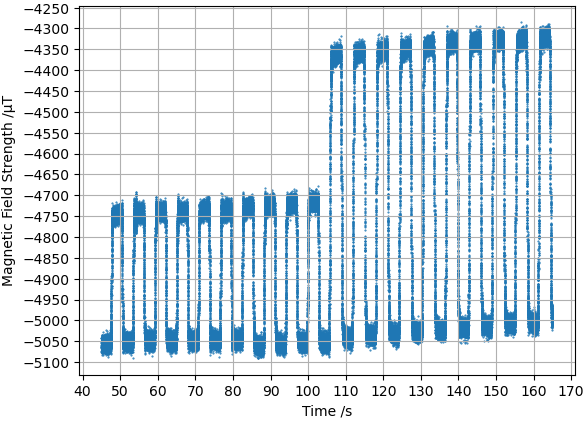

Complete data for the first and second interval interval. Rate of data for this interval is 939.96Hz


In [4]:
# Select a range of timestamps
df_sample = df2.where(df2.timestamp.between(45.0, 165.0));

# Collect values into memory
yAxisCollected      = df_sample.select(df_sample.Y).collect();
timestampsCollected = df_sample.select(df_sample.timestamp).collect();

# And plot them
markerSize = (plt.rcParams['lines.markersize'] ** 2);

# Render this simple sample
plt.scatter(x=timestampsCollected, y=yAxisCollected, marker=".", s=1);
# Style
# The tick locator is from this stack overflow answer: https://stackoverflow.com/a/58675407
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10));
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(25*2));
plt.grid();
plt.xlabel("Time /s");
plt.ylabel("Magnetic Field Strength /µT");

plt.savefig( fFigPathRaster("dense_sample") );
plt.show();
print(f"Complete data for the first and second interval interval. Rate of data for this interval is {df_sample.count() / (165.0-45.0):.2f}Hz");

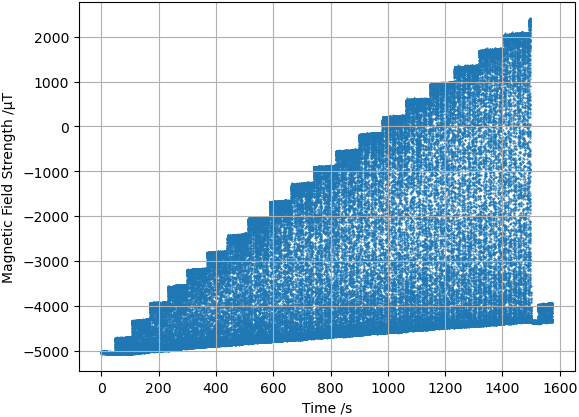

The whole dataset, sampled at 10% containing 154553 readings


In [5]:
# Now we want to get a random sampling of the whole dataset

# Select only 10% of values
df_sample = df2.sample(fraction=0.1, seed=42);

# Collect values into memory
yAxisCollected      = df_sample.select(df_sample.Y).collect();
timestampsCollected = df_sample.select(df_sample.timestamp).collect();

# And plot them
markerSize = (plt.rcParams['lines.markersize'] ** 2);

# Render this simple sample
plt.scatter(x=timestampsCollected, y=yAxisCollected, marker=".", s=1);
plt.grid();
plt.xlabel("Time /s");
plt.ylabel("Magnetic Field Strength /µT");

plt.savefig( fFigPathRaster("sparse_sample") );
plt.show();
print(f"The whole dataset, sampled at 10% containing {df_sample.count()} readings");

In [6]:
# Now we do analysis

# Use of dataclass taken from this stack overflow answer
# https://stackoverflow.com/a/45426493
@dataclass
class Segment:
    #
    # Manually labled values
    #
    
    # Minimum time stamp
    minT                  : float;
    # Maximum time stamp
    maxT                  : float;
    # The values to consider above
    cutoff                : float;
    # What that minimum value has drifted to in the last relevant sample
    cuttoffDrift          : float;
    # The deflection this value represents in millimeters
    deflection            : float;

    # 
    # Computed values
    # 
    drift                 : float = 0.0;
    deltaT                : float = 0.0;
    driffAccumulatedBefore: float = 0.0;
    driftAccBeforeAbsolute: float = 0.0;
    


# A set of segments up to 5mm, manually labeled
segments = [
    Segment(minT=45.0,   maxT=105.0,  cutoff=-4777.5, cuttoffDrift=-4740.0, deflection=1.0),
    Segment(minT=105.0,  maxT=165.0,  cutoff=-4385.0, cuttoffDrift=-4345.0, deflection=2.0),
    Segment(minT=165.0,  maxT=230.0,  cutoff=-3990.0, cuttoffDrift=-3975.0, deflection=3.0),
    Segment(minT=230.0,  maxT=297.5,  cutoff=-3637.5, cuttoffDrift=-3582.5, deflection=4.0),
    Segment(minT=297.5,  maxT=367.5,  cutoff=-3242.5, cuttoffDrift=-3212.5, deflection=5.0)
];

In [7]:
# Compute info about the drift
for i in range(len(segments)):
    # Assign reference
    segment = segments[i];
    segment.drift = (segment.cuttoffDrift - segment.cutoff);
    segment.deltaT = segment.maxT - segment.minT;
    
    # If it's the first value then we have nothing more to compute
    if (i == 0): continue;

    # Assign prev reference
    prevSeg = segments[i-1];

    # Accumulate the drift so we can make sure we're still dealing with good units
    segment.driffAccumulatedBefore = prevSeg.drift + prevSeg.driffAccumulatedBefore;    


In [33]:
def plotSegment(segment, df_seg, coef):
    # Collect values into memory
    yAxisCollected      = df_seg.select(df_seg.Y).collect();
    timestampsCollected = df_seg.select(df_seg.timestamp).collect();
    
    markerSize = (plt.rcParams['lines.markersize'] ** 2);
    
    # Render this simple sample
    plt.scatter(x=timestampsCollected, y=yAxisCollected, marker=".", s=1);
    # Style
    # The tick locator is from this stack overflow answer: https://stackoverflow.com/a/58675407
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5.0));
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10.0));
    plt.grid();
    plt.xlabel("Time /s");
    plt.ylabel("Deflection variance at 149mm from base /µm");
    
    plt.savefig( fFigPathRaster(f"segment_{segment.deflection}mm") );
    plt.show();

    # Print a box-plot and summary stats
    df_seg = df_seg.select(["Y"]).withColumnRenamed("Y", "Deflection variance at 149mm from base /µm");
    df_seg.summary("count", "stddev", "2%", "5%", "25%", "75%", "95%", "98%" ).show();
    
    
    print(f"Deflection at {segment.deflection}mm, {df_seg.count()} samples discarding {100*(1-((df_seg.count() / (segment.maxT - segment.minT)) / data_rate)):.3f}% of samples not at deflection. Coef of deflection {math.pow(coef, -1.0):.3f} µT/mm");

In [ ]:
# Now gather stats
for segment in segments:
    # Get the data in a dataframe
    df_seg = df2.where(df2.timestamp.between(segment.minT, segment.maxT));
    
    # Define UDF to remove drift
    # Define it for every segemnt since we use constants
    @F.udf(returnType=T.DoubleType())
    def removeDrift(field, timestamp):
        # Model the drift as a linear function
        # First we zero the time to the beginning
        # Then we normalise that time
        # And multiply that by the total (local) drift
        driftModel = ((timestamp - segment.minT) / segment.deltaT) * segment.drift;
        
        # Finally, remove the accumulated drift and drift from the local
        # model from the field strength
        #return (field - segment.driffAccumulatedBefore) - driftModel;
        return (field - segment.driffAccumulatedBefore) - driftModel;

    # Then, apply the UDF, overwriting the y column
    df_seg = df_seg.withColumn("Y", removeDrift(df_seg.Y, df_seg.timestamp));

    # Get the minimum value as "zero" deflection
    minimum = df_seg.select(F.min(df_seg.Y)).collect()[0][0]; 

    # We can now apply the cuttoff after applying the inverse of the drift
    df_seg = df_seg.where(df_seg.Y >= (segment.cutoff - (segment.driffAccumulatedBefore)));

    # Make the deflection relative to zero
    df_seg = df_seg.withColumn("Y", df_seg.Y - minimum);
    # Get centroid at this deflection
    median = df_seg.select(F.median(df_seg.Y)).collect()[0][0];
    # Use distance units
    coef   = segment.deflection / median;
    # And get it in variance in µm
    df_seg = df_seg.withColumn("Y", ((df_seg.Y * coef) - segment.deflection) * 1000 );
    
    # And plot them
    plotSegment(segment, df_seg, coef);
    